# Regression Models: OLS, RandomForest and XGBoost algorithms

Predicting vehicle price is a regression problem. In this project we have implemented three regression models. We have implemented a simple linear regression model, Ordinary Least Squares (OLS), to baseline the model performance. Then we have implemented RandomForest and XGBoost models and compared the models.  We have used Mean Absolute Error as our primary model evaluation metric for model selection.   

We have used GridSearchCV hyperparameter tuning method to tune model hyperparameters. However we encounter a few challenges while deploying the model in production, because these challenges we cannot apply the best hyperparameters that GridSearchCV generates. These are real-world challenges data scientist face regularly, we make a few tradeoffs to make the production deployment possible with little impact on model performance.   

A RandomForest with a max_depth of 100 and n_estimators as 200 gives best results, with a MAE of \\$1964, that is within 6.5 percentage margin of error. However, RandomForest model with these hyperparameters produces a compressed pickle file of size over 400MB. Because of limitation on GitHub file sizes and real-world problems, we limited the Random Forest depth to 20 and number of estimators to 50. With these parameters we were able to achieve a MAE of \\$1969 which is only \\$5 less than what was achieved through best estimator from CrossSearchCV.  

We also trained a XGBoost algorithm, With XGBoost we got the advantage of faster training time with less compute resources. XGBoost has various tree_methods such as 'hist' and 'gpu_hist' that can train the model lot faster. We were able train the XGBoost model within a minute with 660K vehicles, while a RandomForest took over 2 minutes. Also, XGBoost pipeline file size is smaller compared to RandomForest.   

XGBoost proced similar or better results compared to RandomForest, we were able to get MAE of \\$1912 from XGBoost algorithem, which is better compared to a MAE of \\$1964 from RandomForest.  

Even though XGBoost produced slightly better results, it lacks the functionality of providing estimation from individual tree. we need this functionality to derive the Confidence Interval (CI) for our vehicle value estimation.


In [1]:
import pandas as pd
import numpy as np

# MLPackages
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Preprocessing pacakges
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split

#Model evaluation packages
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_absolute_error as MAE

# Use a constant random state for reprodesebility
RANDOM_STATE=697

# Graph Plotting packages
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

#We use joblib to pack our ML pipelines
import joblib

%load_ext watermark

%watermark -v -m -p pandas,numpy,joblib,seaborn,matplotlib,warnings,sklearn,xgboost

C:\Users\rafeeshaik\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Python implementation: CPython
Python version       : 3.9.12
IPython version      : 7.32.0

pandas    : 1.4.2
numpy     : 1.21.5
joblib    : 1.1.0
seaborn   : 0.11.2
matplotlib: 3.5.1
warnings  : unknown
sklearn   : 1.0.2
xgboost   : 1.5.2

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 62 Stepping 4, GenuineIntel
CPU cores   : 32
Architecture: 64bit



In [2]:
v_df_orig=pd.read_csv('NotNull_FullDataset.csv',engine='c', memory_map=True)
v_df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1675728 entries, 0 to 1675727
Data columns (total 23 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   price                1675728 non-null  float64
 1   miles                1675728 non-null  float64
 2   year                 1675728 non-null  int64  
 3   make                 1675728 non-null  object 
 4   model                1675728 non-null  object 
 5   trim                 1675728 non-null  object 
 6   vehicle_type         1675728 non-null  object 
 7   body_type            1675728 non-null  object 
 8   drivetrain           1675728 non-null  object 
 9   fuel_type            1675728 non-null  object 
 10  engine_block         1675728 non-null  object 
 11  engine_size          1675728 non-null  float64
 12  transmission         1675728 non-null  object 
 13  doors                1675728 non-null  float64
 14  cylinders            1675728 non-null  float64
 15

In [3]:
# Convert the Categorical columns to string data type. 
# Both Ordinal and OneHot Encoders expect uniform data type while encoding the categorical features

cat_columns = v_df_orig.select_dtypes(include='object').columns
v_df_orig[cat_columns]=v_df_orig[cat_columns].astype(str)

In [4]:
#Keep 1000 vehicle records a side to test the ML models on unseen data

v_df = v_df_orig.sample(frac=0.5, random_state=RANDOM_STATE)
v_df_later_test = v_df_orig.drop(v_df.index)

# Reset the indexes
v_df = v_df.reset_index(drop=True)
v_df_later_test=v_df_later_test.sample(1000, random_state=RANDOM_STATE).reset_index(drop=True)

#Check number of records in each dataframe
print(v_df.shape)
print(v_df_later_test.shape)

(837864, 23)
(1000, 23)


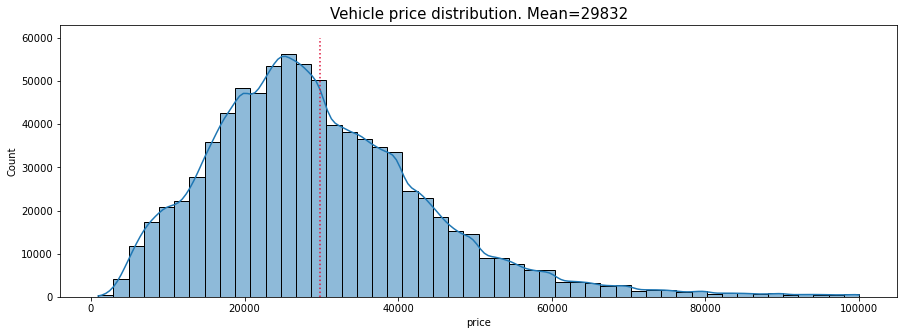

In [5]:
#Plot the price distribution of the vehiles and observe the mean value

fig, ax = plt.subplots(figsize=(15,5))
sns.histplot(data=v_df, x='price', kde=True, bins=50, ax=ax)
mean = int(v_df.price.mean())
title='Vehicle price distribution. Mean='+str(mean)
ax.vlines(mean, 0, 60000, color='crimson', ls=':')
plt.gca().set_title(title, fontsize=15)
plt.show()

## Baseline model: Linear Regressor (OLS)

## Linear regression model pipeline

Linear Regression models except the features to be in numeric format. Here we're implementing OLS as our base line model.
OLS tries to find the fit curv that minimizes the distance between datapoints on linear space. So we need to make sure we're using appropriate encoding mechanism to presever the distance between categorical features. OneHotEncoding solves this categorical feature encoding problem by turing each category into binary values.

In [6]:
X=v_df.drop('price',axis=1)
y=v_df.price

#Categorical columns to apply OneHotEncoding
cat_columns = X.select_dtypes(include='object').columns

# keep 20% of the records for model evaluation

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, test_size=0.2)

#Encoder need to impute '0' if it encounters unseen category. 
onehotenc = OneHotEncoder(handle_unknown='ignore')
onehotenc.fit(X[cat_columns])

#Build the column/feature tranformer
column_trans = make_column_transformer((OneHotEncoder(categories = onehotenc.categories_,handle_unknown='ignore'), cat_columns), remainder='passthrough', n_jobs=-1)

linear_model=LinearRegression(n_jobs=-1) # I would use all the CPU cores to train the model

#Build the pipeline
linear_pipe = Pipeline(steps=[('preprocessor', column_trans),
                      ('model', linear_model)])
#Train the models
linear_pipe.fit(X_train, y_train)

# Evaluate the model
train_score=linear_pipe.score(X_train, y_train)
test_score=linear_pipe.score(X_test, y_test)
print(f'Train score: {train_score}')
print(f'Test score: {test_score}')

## Test the model on unseen data
y_base = v_df_later_test.price
y_hat = linear_pipe.predict(v_df_later_test.drop('price', axis=1))

r2=r2_score(y_base, y_hat)
rmse = MSE(y_base, y_hat, squared=False)
mape = MAPE(y_base, y_hat)
mae = MAE(y_base, y_hat)
print('\nLinear Model Performance on unseen data')
print('Test r2:',r2)
print('RMSE:', rmse)
print('MAPE:', mape)
print('MAE:', mae)

Train score: 0.7531197024529267
Test score: 0.752456960293492

Linear Model Performance on unseen data
Test r2: 0.7408584409643406
RMSE: 7488.0306744170475
MAPE: 0.20459354039356006
MAE: 5110.568370025035


## Decision Tree based models

### Random Forest with OrdinalEncoder and OneHotEncoder to understand if there is any change in the feature importance and model performace

While the Linear Regression models calcuate the differeces between datapoints in a Linear space, the Decision Tree based models identifies the differences/similarities based on the node condition. Decion tree based models dont need the categorical colums to maintain appropriate distances in linear space, so we dont need to apply OneHotEncoder on our categorical columns to maintain equal distaces between category values, we just need to trun the category values into integers, for this reason we have applied OrdinalEncoding on the categorical features before training the ReandomForest and XGBoost models.  

However we have tested the RandomForest model with bost OneHotEncoding and OrdinalEncoding to make sure the results are matching. We have concluded that the RandomForest with OrdinalEncoding is performing similar or better to OneHotEncoding preparocesssor, and feature importance is also same.  

One biggest advantage of using OrdinalEncoder over OneHotEncoder(binary encoding) is reduction in number of feature it produces, Hence it requires less computational resouces and produces smaller model pickle file for easy production deployment.  

With OrdinalEncoding the number of features stays as-is, that is 22 in this case, however with binary encoding number of feature exploded to 2700, this required a lot of computational power and RAM. And the model pickle file size was over 1GB even after applying compression.  

#####  Build the OrdinalEncoder

In [7]:
#categorical columns
v_df_cat = v_df.select_dtypes(include='object')
cat_columns = v_df_cat.columns

#Numerical Columns
v_df_num = v_df.select_dtypes(exclude='object')
v_df_num = v_df_num.drop(['price'], axis=1)


oe = OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1)
oe_cat_data=oe.fit_transform(v_df_cat)


oe_encoded_v_df = pd.DataFrame(oe_cat_data, columns=cat_columns)

X=oe_encoded_v_df.merge(v_df_num, left_index=True, right_index=True)

y=v_df.price

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, test_size=0.20)

#### Train Random Forest Regressor
##### GreadsearchCV for Hyperparameter tuning

In [8]:
from sklearn.model_selection import GridSearchCV

mean_test_scores = None
    
grid={'max_depth':[10, 15, 20, 50, 100], 'n_estimators':[10, 50, 100, 200]}

rfreg = RandomForestRegressor(random_state=RANDOM_STATE,n_jobs=-1)
rfreg_cv=GridSearchCV(rfreg,param_grid = grid,scoring = 'neg_mean_absolute_error')
rfreg_cv.fit(X_train,y_train)
cv_results=rfreg_cv.cv_results_
print("tuned hpyerparameters :(best parameters) ",rfreg_cv.best_params_)
print("absolute_error :",rfreg_cv.best_score_)
#print("cv_results_:",cv_results)

tuned hpyerparameters :(best parameters)  {'max_depth': 100, 'n_estimators': 200}
absolute_error : -1964.9356291729316


In [21]:
mean_test_scores=cv_results['mean_test_score'].reshape(5,4)
neg_MAE=pd.DataFrame(mean_test_scores, index=['Depth_10', 'Depth_15', 'Depth_20', 'Depth_50', 'Depth_100'], columns=['estimators_10', 'estimators_50', 'estimators_100', 'estimators_200'])
neg_MAE

,estimators_10,estimators_50,estimators_100,estimators_200
Depth_10,-3421.549536,-3402.779542,-3400.848361,-3400.445716
Depth_15,-2298.174900,-2262.600524,-2258.321037,-2256.162189
Depth_20,-2051.359098,-1989.210822,-1980.703828,-1976.427538
Depth_50,-2076.133228,-1984.150381,-1971.273941,-1964.944567
Depth_100,-2076.188104,-1984.152637,-1971.272617,-1964.935629


From the interviews we had with domain experts (car dealers) a variation of +/- 10% from the listed price is acceptable price prediction.

So we chose a MAE score that is less than \\$2000, which is 6.7% variation for the vehicles with mean value of \\$29800.

RandomForests produces best results as the max_depth and n_estimators increases, but there is a danger of overfitting the model.
So we can safely select a max_depth of 20 and number of estimators as 50, whihc proced a MAE score of \\$1989 which is less than our target MAE score \\$2000.

In [12]:
rfRegressor = RandomForestRegressor(random_state=RANDOM_STATE,n_jobs=-1, max_depth=20, n_estimators=50)

rfRegressor.fit(X_train, y_train)

train_score=rfRegressor.score(X_train, y_train)

test_score=rfRegressor.score(X_test, y_test)

print('Training score=',train_score)
print('Test score=',test_score)


y_test_hat = rfRegressor.predict(X_test)
mae_test = MAE(y_test, y_test_hat)
print('Test MAE:', mae_test)

Training score= 0.984516335802845
Test score= 0.9634146117989454
Test MAE: 1969.925145052334


#### Random Forest Regressor Feature Importance

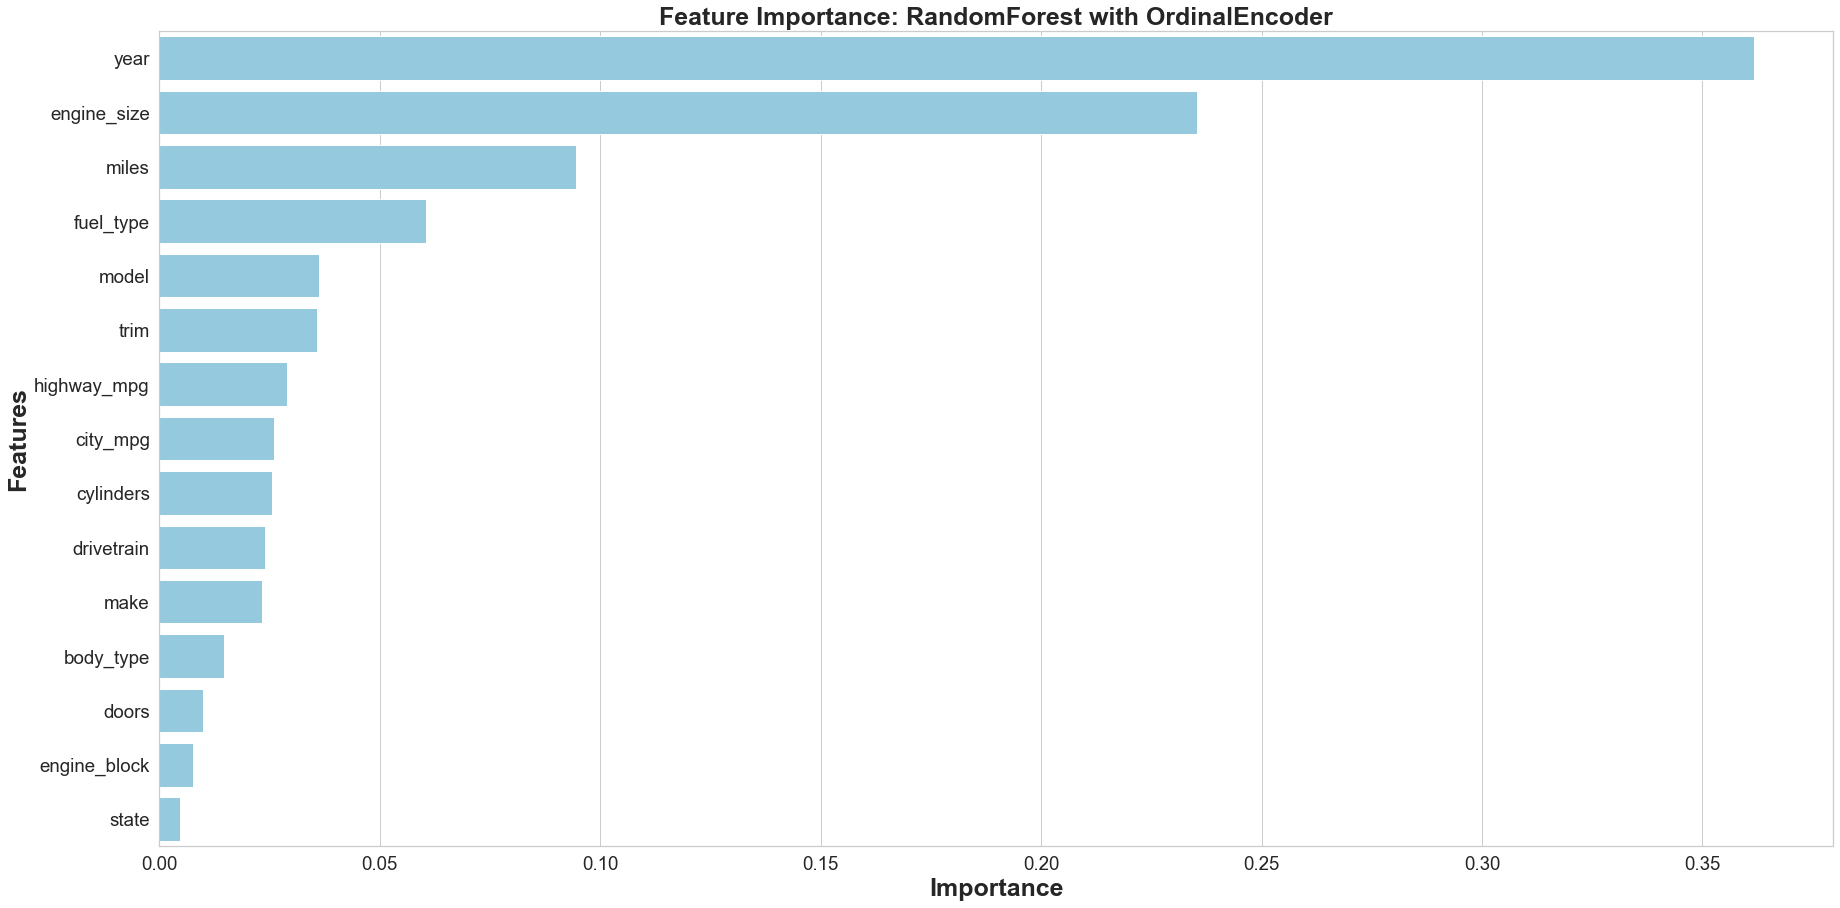

In [13]:
# Feature importance
plt.rcParams["figure.figsize"] = (20,15)

feats = {}
for feature, importance in zip(X.columns, rfRegressor.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})

sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'][:15], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance: RandomForest with OrdinalEncoder', fontsize=25, weight = 'bold')
plt.show()

#### Build and train a XGBoost model

In [14]:
xgb_regressor = xgb.XGBRegressor(
    #enable_categorical=True,
    n_estimators=100,
    reg_lambda=1, # L2 regularization term on weights. Increasing this value will make model more conservative.
    learning_rate=0.3, #learning rate
    gamma=0, # Minimum loss reduction required to make a further partition on a leaf node of the tree. 
             # The larger gamma is, the more conservative the algorithm will be.
    max_depth=15,
    nthread=-1,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    reg_alpha=0, #L1 regularization term on weights. Increasing this value will make model more conservative.
    tree_method='hist'
    
)
## Train the model
xgb_regressor.fit(X_train, y_train)

train_score=xgb_regressor.score(X_train, y_train)

test_score=xgb_regressor.score(X_test, y_test)

print('Training score=',train_score)
print('Test score=',test_score)

y_hat = xgb_regressor.predict(X_test)

print('MAE:', MAE(y_test, y_hat))

Training score= 0.9933304772653181
Test score= 0.9645418526650494
MAE: 1922.496480796365


#### XGBoost model feature importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

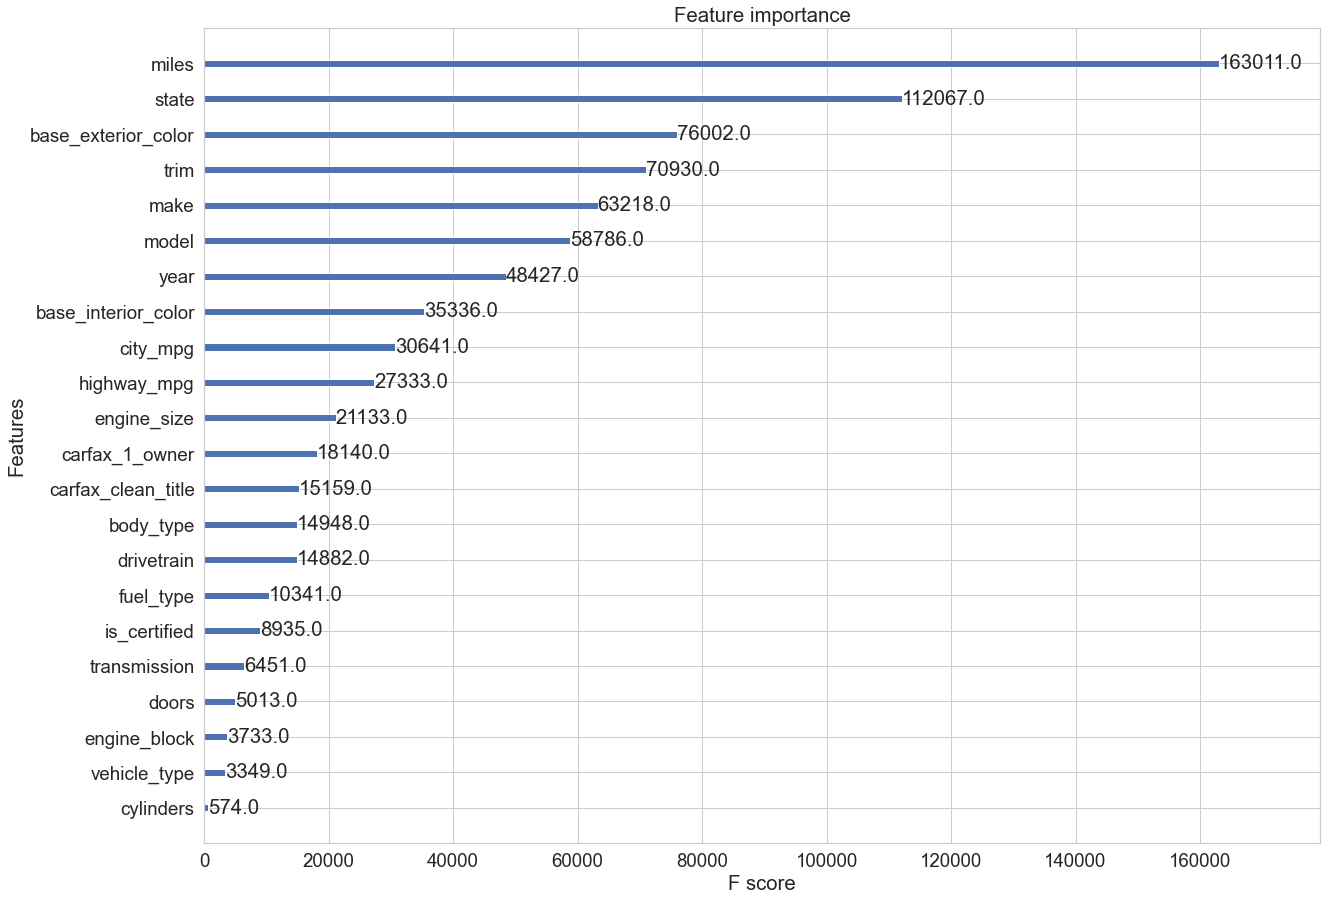

In [15]:
xgb.plot_importance(xgb_regressor)

####  Random foreset model with OneHotEncoder to compare the model performance with OrdinalEncoder model and Feature importance

Training score= 0.9687591238360761
Test score= 0.954378162821651


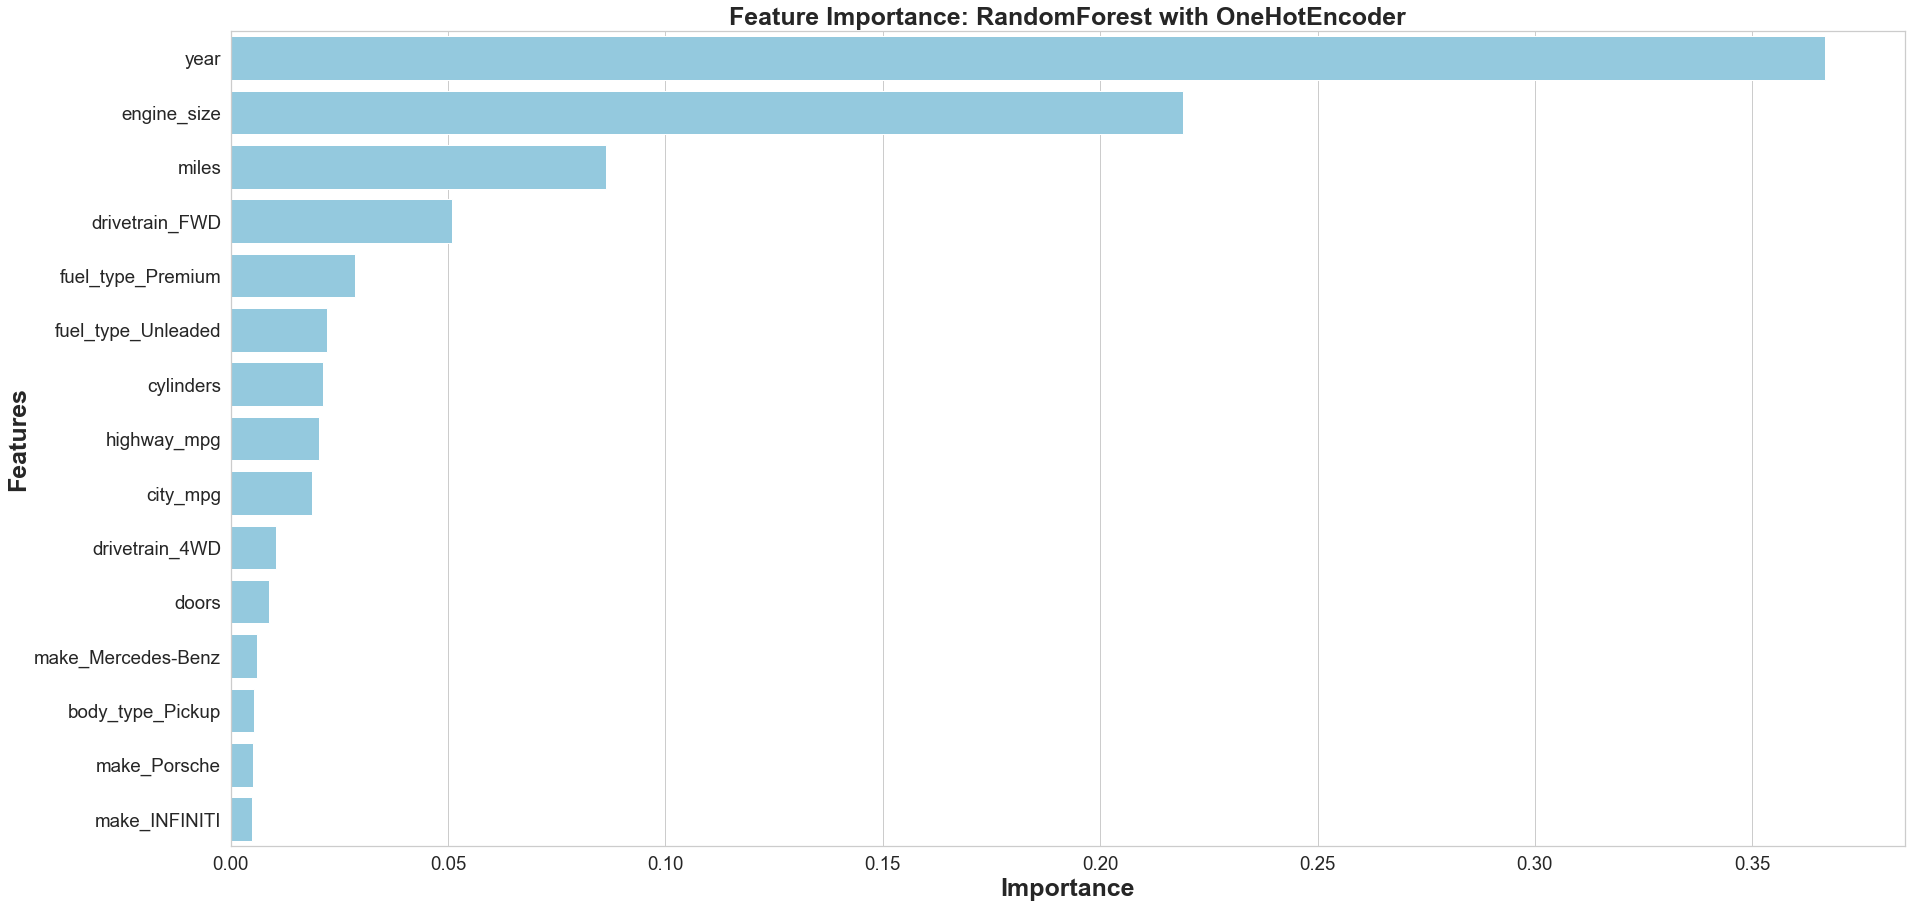

In [15]:
#categorical columns
v_df_cat = v_df.select_dtypes(include='object')
cat_columns = v_df_cat.columns

#Numerical Columns
v_df_num = v_df.select_dtypes(exclude='object')
v_df_num = v_df_num.drop(['price'], axis=1)

enc = OneHotEncoder(handle_unknown = 'ignore')

encoded_cat_data= enc.fit_transform(v_df_cat).toarray()

#print('encoded array size=',encoded_cat_data.shape)

encoded_cat_cols=enc.get_feature_names_out(cat_columns)

v_df_cat_1hot=pd.DataFrame(encoded_cat_data, columns=encoded_cat_cols)

#print('Onehot encoded ds size=',v_df_cat_1hot.shape)

X = v_df_num.merge(v_df_cat_1hot, left_index=True, right_index=True)

y=v_df.price

#print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, test_size=0.2)

#rfRegressor = RandomForestRegressor(random_state=RANDOM_STATE, max_depth=1000, n_estimators=5000, n_jobs=-1).fit(X_train, y_train)
rfRegressor = RandomForestRegressor(random_state=RANDOM_STATE,n_jobs=-1, max_depth=20, n_estimators=50)

rfRegressor.fit(X_train, y_train)

train_score=rfRegressor.score(X_train, y_train)

test_score=rfRegressor.score(X_test, y_test)

print('Training score=',train_score)
print('Test score=',test_score)

# Feature importance
plt.rcParams["figure.figsize"] = (20,15)

feats = {}
for feature, importance in zip(X.columns, rfRegressor.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'][:15], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance: RandomForest with OneHotEncoder', fontsize=25, weight = 'bold')
plt.show()

### Build a RandomForest Pipeline with OrdinalEncoder for production deployment
#### Train, evaluate and test the model and capture model performance metrics such as MAE, MSE and MPAE

In [16]:
X=v_df.drop('price',axis=1)
y=v_df.price

cat_columns = X.select_dtypes(include='object').columns

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, test_size=0.2)

column_trans = make_column_transformer((OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1),\
                                        cat_columns), remainder='passthrough', n_jobs=-1)

rfRegressor = RandomForestRegressor(random_state=RANDOM_STATE,n_jobs=-1, max_depth=20, n_estimators=50)

rf_pipe = Pipeline(steps=[('preprocessor', column_trans),
                      ('estimator', rfRegressor)])

rf_pipe.fit(X_train, y_train)

train_score=rf_pipe.score(X_train, y_train)
test_score=rf_pipe.score(X_test, y_test)
print(f'Train score: {train_score}')
print(f'Test score: {test_score}')


# save as joblib too
filename = 'oe_rf_depth20_50Estimators.sav'
joblib.dump(rf_pipe, filename,compress='zlib')

## Test the model on unseen data
rf_pipeline=joblib.load('oe_rf_depth20_50Estimators.sav')
y_base=v_df_later_test.price
y_hat = rf_pipeline.predict(v_df_later_test.drop('price',axis=1))

r2=r2_score(y_base, y_hat)
rmse = MSE(y_base, y_hat, squared=False)
mape = MAPE(y_base, y_hat)
mae = MAE(y_base, y_hat)
print('\nRandom Forest with OrdinalEncoder Performance on unseen data')
print('Test r2:',r2)
print('RMSE:', rmse)
print('MAPE:', mape)
print('MAE:', mae)

Train score: 0.9845164486186769
Test score: 0.9633809353831329

Random Forest with OrdinalEncoder Performance on unseen data
Test r2: 0.9667640469472498
RMSE: 2681.656514728466
MAPE: 0.07656455240765056
MAE: 1919.2518095559253


```
RF max_depth: 17
Train score: 0.9772131806200048
Test score: 0.9574223025763541
Test score with unseen data: 0.9557488265750609
joblib filesize: 122MB

RF max_depth: 16
Train score: 0.9720707760459801
Test score: 0.9543639238041506
joblib filesize: 87MB

RF max_depth: 15
Train score: 0.9655863494817442
Test score: 0.9499971279076741
Test score with unseen data: 0.9486359985960615
joblib filesize: 60MB

RF max_depth:15, 660K trainng records
Train score: 0.961678338186495
Test score: 0.9532145732660773
Random Forest with OrdinalEncoder Performance on unseen data

Test r2: 0.9499163445973978
RMSE: 3189.1862641321522
MAPE: 0.0916317648356867
MAE: 2239.3001805829963

```

## Build an XGBoost Pipeline for produciton deployment,
#### Test the model on unseen data, capture the model performace metrics, MAE, MSE and MPAE

In [17]:
cat_columns = v_df.select_dtypes(include='object').columns

X=v_df.drop('price',axis=1)
y=v_df.price

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, test_size=0.2)

column_trans = make_column_transformer((OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1), cat_columns)\
                                       , remainder='passthrough', n_jobs=-1)

print("Features that XGB Model trained on are: ",X_train.columns)

xgb_regressor = xgb.XGBRegressor(
    #enable_categorical=True,
    n_estimators=100,
    reg_lambda=1, # L2 regularization term on weights. Increasing this value will make model more conservative.
    learning_rate=0.3, #learning rate
    gamma=0, # Minimum loss reduction required to make a further partition on a leaf node of the tree. 
             # The larger gamma is, the more conservative the algorithm will be.
    max_depth=10,
    nthread=-1,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    reg_alpha=0, #L1 regularization term on weights. Increasing this value will make model more conservative.
    tree_method='hist'
    
)

xgb_pipe = Pipeline(steps=[('preprocessor', column_trans),
                      ('xgb_estimator', xgb_regressor)])

xgb_pipe.fit(X_train, y_train)

train_score=xgb_pipe.score(X_train, y_train)
test_score=xgb_pipe.score(X_test, y_test)
print(f'Train score: {train_score}')
print(f'Test score: {test_score}')


y_test_hat = xgb_pipe.predict(X_test)
r2=r2_score(y_test, y_test_hat)
rmse = MSE(y_test, y_test_hat, squared=False)
mape = MAPE(y_test, y_test_hat)
mae = MAE(y_test, y_test_hat)
print('\nModel evaluation metrics')
print('Test r2:',r2)
print('RMSE:', rmse)
print('MAPE:', mape)
print('MAE:', mae)


# pickle the pipeline
filename = 'oe_xgb_depth15_660k.sav'
joblib.dump(xgb_pipe, filename,compress='zlib')

## Test the model on unseen data
xgbPipe = joblib.load('oe_xgb_depth15_660k.sav')

y_base = v_df_later_test.price
y_hat = xgbPipe.predict(v_df_later_test.drop('price', axis=1))

r2=r2_score(y_base, y_hat)
rmse = MSE(y_base, y_hat,squared=False)
mape = MAPE(y_base, y_hat)
mae = MAE(y_base, y_hat)
print('\nModel Performance on unseen data')
print('Test r2:',r2)
print('RMSE:', rmse)
print('MAPE:', mape)
print('MAE:', mae)

Features that XGB Model trained on are:  Index(['miles', 'year', 'make', 'model', 'trim', 'vehicle_type', 'body_type',
       'drivetrain', 'fuel_type', 'engine_block', 'engine_size',
       'transmission', 'doors', 'cylinders', 'city_mpg', 'highway_mpg',
       'base_exterior_color', 'base_interior_color', 'is_certified', 'state',
       'carfax_1_owner', 'carfax_clean_title'],
      dtype='object')
Train score: 0.9749281546863365
Test score: 0.9653864340919711

Model evaluation metrics
Test r2: 0.9653864340919711
RMSE: 2711.712011380239
MAPE: 0.07705196930555101
MAE: 1912.9866467244872

Model Performance on unseen data
Test r2: 0.9695810063866667
RMSE: 2565.496946208321
MAPE: 0.07137385439119263
MAE: 1814.7760895996093


``` 
on small dataset
lambda = 1
gamma = 0
alpha=0
Train score: 0.9980085419583822
Test score: 0.958927096617573
unseen data score: 0.9590292274602698

Test r2: 0.958927096617573
MSE: 3263.2418360970014
MAPE: 0.08397233873324149
MAE: 2127.082774416151

lambda = 2
gamma = 0.1
alpha=0.1
Train score: 0.9969219268505003
Test score: 0.9580760141757222
unseen data score: 0.9588934909255152

on large dataset
Train score: 0.991762348839164
Test score: 0.9694065866215774

Test r2: 0.9694065866215774
RMSE: 2842.181574956708
MAPE: 489745564885676.6
MAE: 1892.8839018355093
test on unseen data:
Test r2: 0.9698632434328543
RMSE: 2814.077625818853
MAPE: 0.07504153664868393
MAE: 1879.854613707545

```

# ML Model with only Make, Model and Trim information

Train score: 0.977534176245357
Test score: 0.9520460403850051

Random Forest with OrdinalEncoder Performance on unseen data
Test r2: 0.9580656702365833
RMSE: 3012.200901976514
MAPE: 0.08121289976314301
MAE: 2095.747571095699


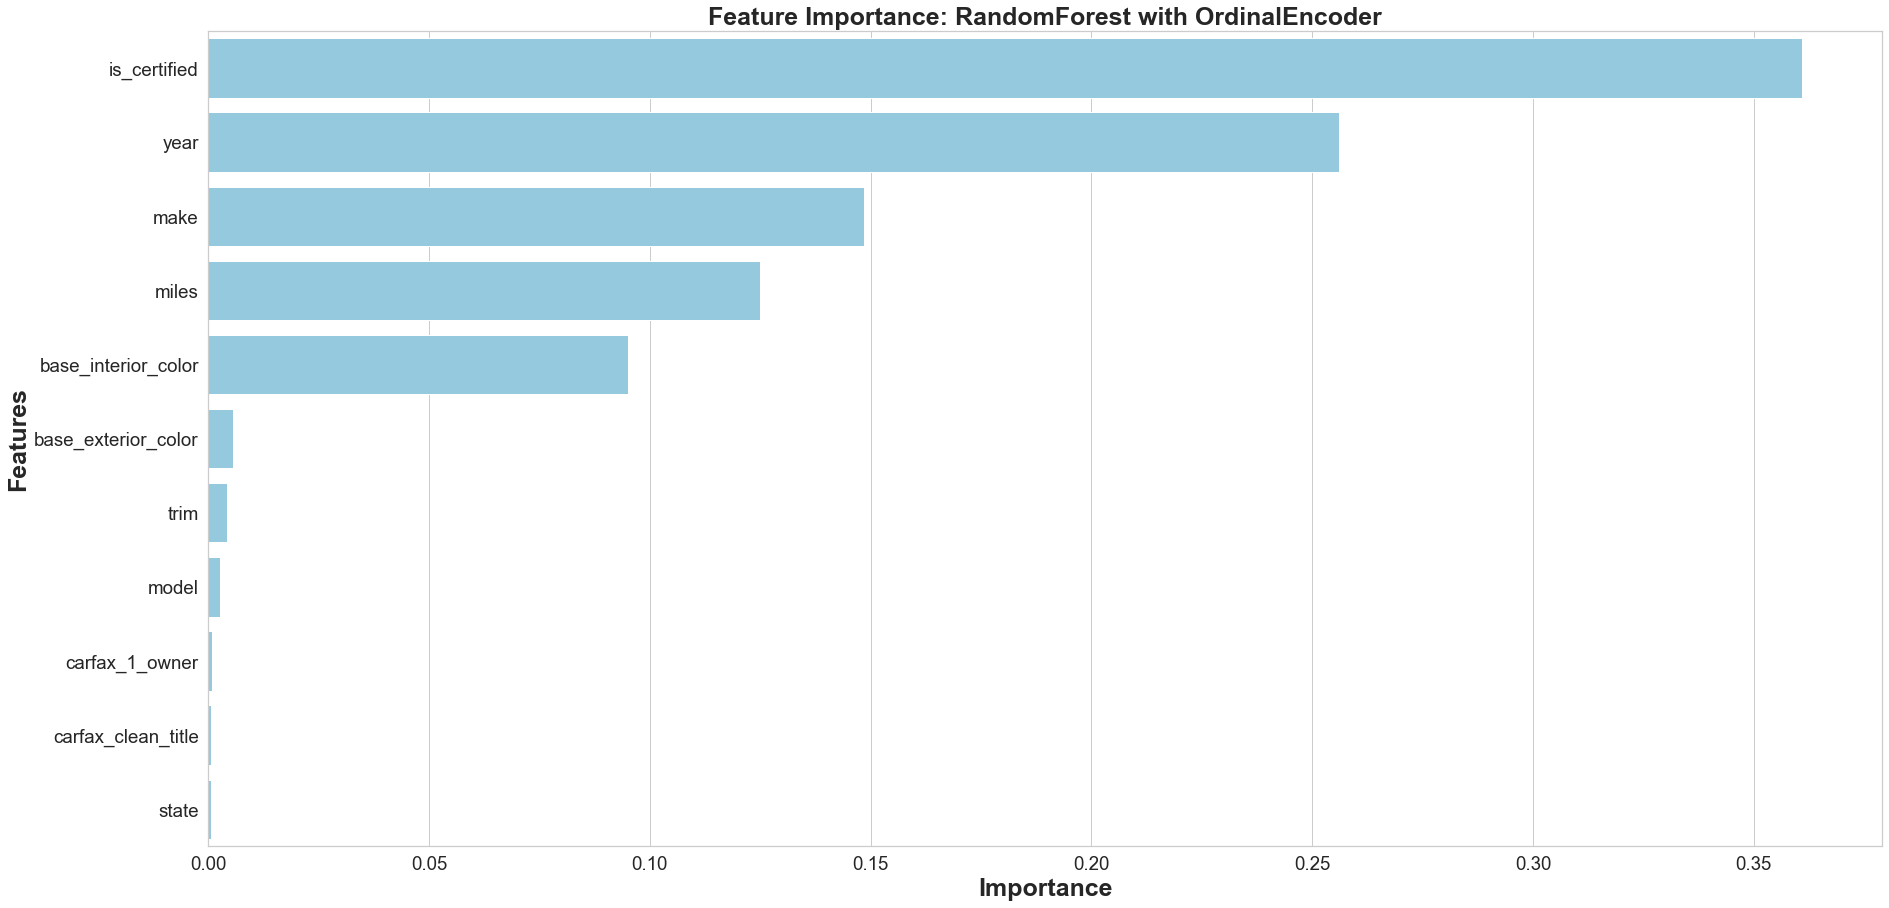

In [18]:
v_df_nospec = v_df[['price', 'miles', 'year', 'make', 'model', 'trim', 
       'base_exterior_color', 'base_interior_color', 'is_certified', 'state',
       'carfax_1_owner', 'carfax_clean_title']]

cat_columns = v_df_nospec.select_dtypes(include='object').columns

X=v_df_nospec.drop('price',axis=1)
y=v_df_nospec.price

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, test_size=0.2)

column_trans = make_column_transformer((OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1), cat_columns)\
                                       , remainder='passthrough', n_jobs=-1)


fRegressor = RandomForestRegressor(random_state=RANDOM_STATE,n_jobs=-1, max_depth=20, n_estimators=50)

rf_pipe = Pipeline(steps=[('preprocessor', column_trans),
                      ('estimator', rfRegressor)])

rf_pipe.fit(X_train, y_train)

train_score=rf_pipe.score(X_train, y_train)
test_score=rf_pipe.score(X_test, y_test)
print(f'Train score: {train_score}')
print(f'Test score: {test_score}')


# save as joblib too
filename = 'oe_rf_depth20_50Estimators.sav'
joblib.dump(rf_pipe, filename,compress='zlib')

## Test the model on unseen data
rf_pipeline=joblib.load('oe_rf_depth20_50Estimators.sav')
y_base=v_df_later_test.price
y_hat = rf_pipeline.predict(v_df_later_test.drop('price',axis=1))

r2=r2_score(y_base, y_hat)
rmse = MSE(y_base, y_hat, squared=False)
mape = MAPE(y_base, y_hat)
mae = MAE(y_base, y_hat)
print('\nRandom Forest with OrdinalEncoder Performance on unseen data')
print('Test r2:',r2)
print('RMSE:', rmse)
print('MAPE:', mape)
print('MAE:', mae)

# Feature importance
plt.rcParams["figure.figsize"] = (20,15)

feats = {}
for feature, importance in zip(X.columns, rfRegressor.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})

sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'][:15], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance: RandomForest with OrdinalEncoder', fontsize=25, weight = 'bold')
plt.show()